In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from xgboost import plot_importance
import numpy as np
from sklearn.metrics import confusion_matrix

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

C:\Users\MERCER\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



# Read all train datasets

In [2]:
train_data = pd.read_csv("Train/train.csv")
view_log = pd.read_csv("Train/view_log.csv")
item_data = pd.read_csv("Train/item_data.csv")

In [3]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [4]:
len(train_data.user_id.unique())

74723

In [5]:
# Total Number of unique item_id in view log and item_data
len(view_log.groupby("item_id")),len(item_data.groupby("item_id"))

(126708, 132761)

# Read test data

In [6]:
test_data = pd.read_csv("Test/test.csv")
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1


In [7]:
train_data.shape,view_log.shape,item_data.shape,test_data.shape

((237609, 7), (3118622, 5), (132761, 6), (90675, 6))

In [8]:
# Check number of common user_id in train & view_log or in test and view_log

print("Number of user_id common in train & view_log data ",train_data['user_id'].isin(view_log['user_id']).value_counts())
print("*"*80)

print("Number of user_id common in test & view_log data ",test_data['user_id'].isin(view_log['user_id']).value_counts())

Number of user_id common in train & view_log data  True    237609
Name: user_id, dtype: int64
********************************************************************************
Number of user_id common in test & view_log data  True    90675
Name: user_id, dtype: int64


# Merge train_data & view_log data

In [9]:
train_data.shape,view_log.shape

((237609, 7), (3118622, 5))

In [10]:
train_view_data = train_data.merge(view_log,on = 'user_id',how = 'left')

print("Shape of train_view_data : ",train_view_data.shape)

train_view_data.head(3)

Shape of train_view_data :  (11052882, 11)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-10-19 18:11:00,android,190710,43886
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,43209
2,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,66370


In [11]:
item_data.shape

(132761, 6)

In [12]:
# Total Number of unique item_id in train_view_data
print( 'Total no. of unique item_id:',len(train_view_data.groupby("item_id")))


Total no. of unique item_id: 117249


In [13]:
test_view_data = test_data.merge(view_log,on = 'user_id',how = 'left')

print("Shape of train_view_data : ",test_view_data.shape)

test_view_data.head(3)

Shape of train_view_data :  (3871697, 10)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018-12-11 19:01:00,android,923045,128995
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:47:00,android,368797,55912
2,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:48:00,android,368797,80771


In [14]:
# Check number of common user_id in train & view_log or in test and view_log

print("Number of item_id common in train_view_data & item_data  ",train_view_data['item_id'].isin(item_data['item_id']).value_counts())
print("*"*80)

print("Number of item_id common in test_view_data & item_data  ",test_view_data['item_id'].isin(item_data['item_id']).value_counts())

Number of item_id common in train_view_data & item_data   True     11046039
False        6843
Name: item_id, dtype: int64
********************************************************************************
Number of item_id common in test_view_data & item_data   True     3869280
False       2417
Name: item_id, dtype: int64


In [15]:
len(item_data.item_id.unique()),item_data.shape

(132761, (132761, 6))

In [16]:
len(train_view_data.item_id.unique()),train_view_data.shape

(117249, (11052882, 11))

In [17]:
train_final = train_view_data.merge(item_data,on = 'item_id',how = 'left')

print("Shape of train_view_data : ",train_final.shape)

train_final.head(3)

Shape of train_view_data :  (11052882, 16)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-10-19 18:11:00,android,190710,43886,2350.0,11.0,35.0,20.0,5622.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,43209,3421.0,4.0,74.0,292.0,577.0
2,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,66370,14166.0,4.0,74.0,292.0,3399.0


In [18]:
train_final.isnull().sum()

impression_id         0
impression_time       0
user_id               0
app_code              0
os_version            0
is_4G                 0
is_click              0
server_time           0
device_type           0
session_id            0
item_id               0
item_price         6843
category_1         6843
category_2         6843
category_3         6843
product_type       6843
dtype: int64

In [19]:
test_final = test_view_data.merge(item_data,on = 'item_id',how = 'left')

print("Shape of train_view_data : ",test_final.shape)

test_final.head(3)

Shape of train_view_data :  (3871697, 15)


,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018-12-11 19:01:00,android,923045,128995,23424.0,1.0,42.0,220.0,1617.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:47:00,android,368797,55912,1529.0,9.0,44.0,114.0,9857.0
2,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:48:00,android,368797,80771,11697.0,9.0,3.0,48.0,6347.0


In [20]:
test_final.isnull().sum()

impression_id         0
impression_time       0
user_id               0
app_code              0
os_version            0
is_4G                 0
server_time           0
device_type           0
session_id            0
item_id               0
item_price         2417
category_1         2417
category_2         2417
category_3         2417
product_type       2417
dtype: int64

In [21]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(train_final['item_price'].as_matrix().reshape(-1,1))

a=imp_mean.transform(train_final['item_price'].as_matrix().reshape(-1,1))
b = imp_mean.transform(test_final['item_price'].as_matrix().reshape(-1,1))

In [22]:
train_final['item_price'] = a
test_final['item_price'] = b

In [23]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_final['category_1'].as_matrix().reshape(-1,1))

a1=imp_mean.transform(train_final['category_1'].as_matrix().reshape(-1,1))
b1=imp_mean.transform(test_final['category_1'].as_matrix().reshape(-1,1))

In [24]:
train_final['category_1'] = a1
test_final['category_1'] = b1

In [25]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_final['category_2'].as_matrix().reshape(-1,1))

a2=imp_mean.transform(train_final['category_2'].as_matrix().reshape(-1,1))
b2=imp_mean.transform(test_final['category_2'].as_matrix().reshape(-1,1))

In [26]:
train_final['category_2'] = a2
test_final['category_2'] = b2

In [27]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_final['category_3'].as_matrix().reshape(-1,1))

a3=imp_mean.transform(train_final['category_3'].as_matrix().reshape(-1,1))
b3=imp_mean.transform(test_final['category_3'].as_matrix().reshape(-1,1))

In [28]:
train_final['category_3'] = a3
test_final['category_3'] = b3

In [29]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(train_final['product_type'].as_matrix().reshape(-1,1))

a4=imp_mean.transform(train_final['product_type'].as_matrix().reshape(-1,1))
b4=imp_mean.transform(test_final['product_type'].as_matrix().reshape(-1,1))

In [30]:
train_final['product_type'] = a4
test_final['product_type'] = b4


In [31]:
train_final.isnull().sum()

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
server_time        0
device_type        0
session_id         0
item_id            0
item_price         0
category_1         0
category_2         0
category_3         0
product_type       0
dtype: int64

In [32]:
test_final.isnull().sum()

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
server_time        0
device_type        0
session_id         0
item_id            0
item_price         0
category_1         0
category_2         0
category_3         0
product_type       0
dtype: int64

In [33]:
train_final.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-10-19 18:11:00,android,190710,43886,2350.0,11.0,35.0,20.0,5622.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,43209,3421.0,4.0,74.0,292.0,577.0
2,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-10-21 06:13:00,android,356854,66370,14166.0,4.0,74.0,292.0,3399.0


In [34]:
test_final.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018-12-11 19:01:00,android,923045,128995,23424.0,1.0,42.0,220.0,1617.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:47:00,android,368797,55912,1529.0,9.0,44.0,114.0,9857.0
2,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-10-16 10:48:00,android,368797,80771,11697.0,9.0,3.0,48.0,6347.0


In [35]:
test_final.shape,train_final.shape

((3871697, 15), (11052882, 16))

# Copy Train & Test

In [36]:
train_orignal = train_final.copy()
test_orignal = test_final.copy()

# Convert Date Time

In [37]:
# dateTime is object so convert it in datetime
from datetime import datetime 
train_final['impression_time'] = pd.to_datetime(train_final.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_final['impression_time'] = pd.to_datetime(test_final.impression_time,format='%Y-%m-%d %H:%M:%S')
train_orignal['impression_time'] = pd.to_datetime(train_orignal.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_orignal['impression_time'] = pd.to_datetime(test_orignal.impression_time,format='%Y-%m-%d %H:%M:%S')


train_final['server_time'] = pd.to_datetime(train_final.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_final['server_time'] = pd.to_datetime(test_final.impression_time,format='%Y-%m-%d %H:%M:%S')
train_orignal['server_time'] = pd.to_datetime(train_orignal.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_orignal['server_time'] = pd.to_datetime(test_orignal.impression_time,format='%Y-%m-%d %H:%M:%S')

In [38]:
# We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

for i in (train_final, test_final, train_orignal, test_orignal):
    i['imp_year']=i.impression_time.dt.year 
    i['imp_month']=i.impression_time.dt.month 
    i['imp_day']=i.impression_time.dt.day
    i['imp_Hour']=i.impression_time.dt.hour
    i['imp_min'] = i.impression_time.dt.minute
    
    
    i['st_year']=i.server_time.dt.year 
    i['st_month']=i.server_time.dt.month 
    i['st_day']=i.server_time.dt.day
    i['st_Hour']=i.server_time.dt.hour
    i['st_min'] = i.server_time.dt.minute
    
    

In [39]:
train_final['imp day of week']=train_final['impression_time'].dt.dayofweek 
temp = train_final['impression_time']


test_final['imp day of week']=test_final['impression_time'].dt.dayofweek 
temp = test_final['impression_time']

train_final['st day of week']=train_final['server_time'].dt.dayofweek 
temp = train_final['server_time']


test_final['st day of week']=test_final['server_time'].dt.dayofweek 
temp = test_final['server_time']


In [40]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train_final['impression_time'].apply(applyer) 
train_final['imp_weekend']=temp2

temp2 = test_final['impression_time'].apply(applyer) 
test_final['imp_weekend']=temp2



temp2 = train_final['server_time'].apply(applyer) 
train_final['st_weekend']=temp2

temp2 = test_final['server_time'].apply(applyer) 
test_final['st_weekend']=temp2




In [41]:
train_final.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,...,imp_min,st_year,st_month,st_day,st_Hour,st_min,imp day of week,st day of week,imp_weekend,st_weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-11-15 00:00:00,android,190710,...,0,2018,11,15,0,0,3,3,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-11-15 00:01:00,android,356854,...,1,2018,11,15,0,1,3,3,0,0
2,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-11-15 00:01:00,android,356854,...,1,2018,11,15,0,1,3,3,0,0


In [42]:
test_final.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id,...,imp_min,st_year,st_month,st_day,st_Hour,st_min,imp day of week,st day of week,imp_weekend,st_weekend
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018-12-13 07:44:00,android,923045,128995,...,44,2018,12,13,7,44,3,3,0,0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-12-13 07:45:00,android,368797,55912,...,45,2018,12,13,7,45,3,3,0,0
2,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018-12-13 07:45:00,android,368797,80771,...,45,2018,12,13,7,45,3,3,0,0


In [43]:
test_final.shape,train_final.shape

((3871697, 29), (11052882, 30))

In [44]:
#Deduplication of entries
train_final = train_final.drop_duplicates(subset=train_final.columns, keep='first', inplace=False)
train_final.shape

(8704057, 30)

In [45]:
#Deduplication of entries
train_final = train_final.drop_duplicates(subset={"impression_id","impression_time","user_id","app_code","os_version","is_4G"}, keep='first', inplace=False)
train_final.shape

(237609, 30)

In [46]:
#Deduplication of entries
test_final = test_final.drop_duplicates(subset=test_final.columns, keep='first', inplace=False)
test_final.shape

(3055644, 29)

In [47]:
#Deduplication of entries
test_final = test_final.drop_duplicates(subset={"impression_id","impression_time","user_id","app_code","os_version","is_4G"}, keep='first', inplace=False)
test_final.shape

(90675, 29)

# EDA

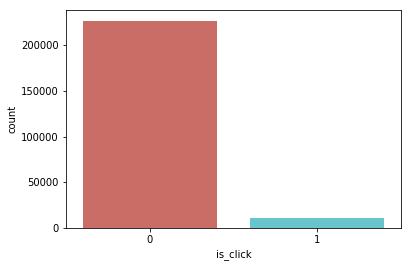

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='is_click',data=train_data, palette='hls')
plt.show();

In [ ]:
train_data['is_click'].value_counts()/len(train_data)

The Overall CTR is approx 4 % and approx 96 % not clicked

In [ ]:
train_data.impression_time.describe()

In [ ]:
train_data.groupby('Hour').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

The highest number of clicks is at hour 0 and 22 (mid-night and 10pm), and the lowest number of clicks is at hour 3-4 (3pm & 4pm)

In [ ]:
train_data.groupby(['day', 'is_click']).size().unstack().plot(kind='bar', title="day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

On day 13 there is no clicks and max click is on day 3 & day 27

### CTR is the ratio of ad clicks to impressions. It measures the rate of clicks on each ad.

## Hourly CTR

In [ ]:
import seaborn as sns
df_click = train_data[train_data['is_click'] == 1]
df_hour = train_data[['Hour','is_click']].groupby(['Hour']).count().reset_index()
df_hour = df_hour.rename(columns={'is_click': 'impressions'})
df_hour['is_click'] = df_click[['Hour','is_click']].groupby(['Hour']).count().reset_index()['is_click']
df_hour['CTR'] = df_hour['is_click']/df_hour['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='Hour', data=df_hour)
plt.title('Hourly CTR');

Highest number of CTR is on 3,4 and as we know impression & clicks on 3,4 is very less

# Day Of Week

In [ ]:
train_data['day_of_week'] = train_data['impression_time'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_data.groupby('day_of_week').agg({'is_click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

In [ ]:
train_data.groupby(['day_of_week','is_click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

Wed , Fri ,Sat & Sun have less number of clicks and impression and Tues have more number of clicks

## Day of week CTR

In [ ]:
df_click = train_data[train_data['is_click']==1]
df_dayofweek = train_data[['day_of_week','is_click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'is_click': 'impressions'})
df_dayofweek['is_click'] = df_click[['day_of_week','is_click']].groupby(['day_of_week']).count().reset_index()['is_click']
df_dayofweek['CTR'] = df_dayofweek['is_click']/df_dayofweek['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

Tue have lowest and Sat Sun Mon have highest CTR

# min

In [ ]:


train_data.groupby('min').agg({'is_click':'sum'}).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear

plt.title('click trends by min');

In [ ]:
train_data.groupby(['min','is_click']).size().unstack().plot(kind='bar', title="min", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear


plt.title('Impressions vs. clicks by min');

# MIN CTR

In [ ]:
df_click = train_data[train_data['is_click']==1]
df_min = train_data[['min','is_click']].groupby(['min']).count().reset_index()
df_min = df_min.rename(columns={'is_click': 'impressions'})
df_min['is_click'] = df_click[['min','is_click']].groupby(['min']).count().reset_index()['is_click']
df_min['CTR'] = df_min['is_click']/df_min['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='min', data=df_min)
plt.title('min CTR')

# EDA on app_code

In [ ]:


train_data.groupby('app_code').agg({'is_click':'sum'}).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear

plt.title('click trends by app_code');

In [ ]:
print(train_data.app_code.value_counts()/len(train_data))

app_code 207 have 14.22 % Clicks

## CTR of aap_code

In [ ]:
app_code_values = train_data.app_code.unique()
app_code_values.sort()
ctr_avg_list=[]
for i in app_code_values:
    ctr_avg=train_data.loc[np.where((train_data.app_code == i))].is_click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

204,380,451,517 have 25 % , 452 have 27.27 % CTR ,CTR & 315,408,479 have 100 % CTR

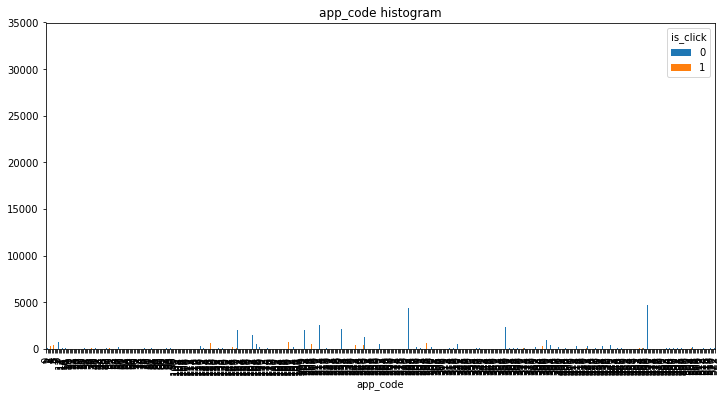

In [35]:
train_data.groupby(['app_code', 'is_click']).size().unstack().plot(kind='bar', figsize=(12,6), title='app_code histogram');

# is_4G

In [36]:
print(train_data.is_4G.value_counts()/len(train_data))

0    0.638688
1    0.361312
Name: is_4G, dtype: float64


Approx 64 % have not 4g and 36 % have 4g connection

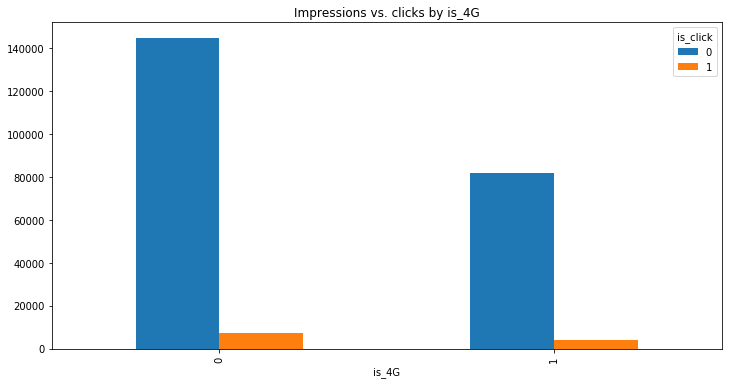

In [37]:
train_data.groupby(['is_4G','is_click']).size().unstack().plot(kind='bar', title="is_4G", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear


plt.title('Impressions vs. clicks by is_4G');

# CTR of is_4g

In [38]:
is_4G_values = train_data.is_4G.unique()
is_4G_values.sort()
ctr_avg_list=[]
for i in is_4G_values:
    ctr_avg=train_data.loc[np.where((train_data.is_4G == i))].is_click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 0,  click through rate: 0.04625785790534931
for C1 value: 1,  click through rate: 0.04475195396675636


# os_version

def os(row):
    if row == 'old' :
        return 0
    elif row == 'intermediate':
        return 1
    elif row == 'latest':
        return 2
    
temp2 = train_final['os_version'].apply(os) 
train_final['os__version']=temp2

temp2 = test_final['os_version'].apply(os) 
test_final['os__version']=temp2


In [46]:
train_final.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,...,st_year,st_month,st_day,st_Hour,st_min,imp day of week,st day of week,imp_weekend,st_weekend,os__version
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018-11-15 00:00:00,android,190710,...,2018,11,15,0,0,3,3,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-11-15 00:01:00,android,356854,...,2018,11,15,0,1,3,3,0,0,2
2,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018-11-15 00:01:00,android,356854,...,2018,11,15,0,1,3,3,0,0,2


In [41]:
print('The impressions by os_version types')
print((train_data.os_version.value_counts()/len(train_data)))

The impressions by os_version types
latest          0.543818
intermediate    0.233758
old             0.222424
Name: os_version, dtype: float64


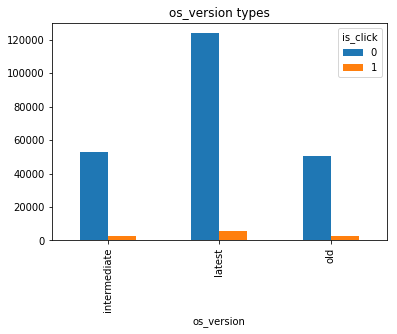

In [42]:
train_data[['os_version','is_click']].groupby(['os_version','is_click']).size().unstack().plot(kind='bar', title='os_version types');

In [43]:
device_type_click = df_click.groupby('os_version').agg({'is_click':'sum'}).reset_index()
device_type_impression = train_data.groupby('os_version').agg({'is_click':'count'}).reset_index().rename(columns={'is_click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'os_version')
merged_device_type['CTR'] = merged_device_type['is_click'] / merged_device_type['impressions']*100
merged_device_type

,os_version,is_click,impressions,CTR
0,intermediate,2875,55543,5.176170
1,latest,5382,129216,4.165119
2,old,2605,52850,4.929044


In [52]:
train_final['device_type'].value_counts()

android    11049891
iphone         2875
web             116
Name: device_type, dtype: int64

In [48]:
train_final.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'server_time', 'device_type', 'session_id',
       'item_id', 'item_price', 'category_1', 'category_2', 'category_3',
       'product_type', 'imp_year', 'imp_month', 'imp_day', 'imp_Hour',
       'imp_min', 'st_year', 'st_month', 'st_day', 'st_Hour', 'st_min',
       'imp day of week', 'st day of week', 'imp_weekend', 'st_weekend',
       'os__version'],
      dtype='object')

# One Hot Encoding

In [49]:
train_final = pd.get_dummies(data = train_final,columns = ["os_version","device_type"])

train_final.head(3)

,impression_id,impression_time,user_id,app_code,is_4G,is_click,server_time,session_id,item_id,item_price,...,imp day of week,st day of week,imp_weekend,st_weekend,os_version_intermediate,os_version_latest,os_version_old,device_type_android,device_type_iphone,device_type_web
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,0,0,2018-11-15 00:00:00,190710,43886,2350.0,...,3,3,0,0,0,0,1,1,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,2018-11-15 00:01:00,356854,43209,3421.0,...,3,3,0,0,0,1,0,1,0,0
13,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,1,0,2018-11-15 00:02:00,658178,122348,973.0,...,3,3,0,0,1,0,0,1,0,0


In [50]:
test_final = pd.get_dummies(data = test_final,columns = ["os_version","device_type"])

test_final.head(3)

,impression_id,impression_time,user_id,app_code,is_4G,server_time,session_id,item_id,item_price,category_1,...,imp day of week,st day of week,imp_weekend,st_weekend,os_version_intermediate,os_version_latest,os_version_old,device_type_android,device_type_iphone,device_type_web
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,1,2018-12-13 07:44:00,923045,128995,23424.0,1.0,...,3,3,0,0,0,1,0,1,0,0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,0,2018-12-13 07:45:00,368797,55912,1529.0,9.0,...,3,3,0,0,0,1,0,1,0,0
73,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,1,2018-12-13 07:46:00,568979,94943,20309.0,9.0,...,3,3,0,0,0,1,0,1,0,0


In [51]:
test_final_imp_id = test_final["impression_id"]

In [52]:
train_final.drop(columns = ["impression_id","impression_time","user_id","server_time",'session_id','item_id'],inplace = True)

test_final.drop(columns = ["impression_id","impression_time","user_id","server_time",'session_id','item_id'],inplace = True)



In [53]:
train_final.head(3)

,app_code,is_4G,is_click,item_price,category_1,category_2,category_3,product_type,imp_year,imp_month,...,imp day of week,st day of week,imp_weekend,st_weekend,os_version_intermediate,os_version_latest,os_version_old,device_type_android,device_type_iphone,device_type_web
0,422,0,0,2350.0,11.0,35.0,20.0,5622.0,2018,11,...,3,3,0,0,0,0,1,1,0,0
1,467,1,1,3421.0,4.0,74.0,292.0,577.0,2018,11,...,3,3,0,0,0,1,0,1,0,0
13,259,1,0,973.0,13.0,67.0,170.0,2874.0,2018,11,...,3,3,0,0,1,0,0,1,0,0


In [54]:
train_final.shape,test_final.shape

((237609, 28), (90675, 27))

# Train Models

# XGB

In [94]:
import xgboost as xgb

xb_clf1=xgb.XGBClassifier(objective = "binary:logistic" ,eval_metric= 'auc',n_estimators = 50,max_depth = 50,reg_lambda = 100,reg_alpha = 0.01,colsample_bytree = 0.5,subsample = 0.9,eta = 0.01,min_child_weight = 0.1,class_weight = "balanced")
xb_clf1.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
       eta=0.01, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=50, min_child_weight=0.1, missing=None,
       n_estimators=50, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.01,
       reg_lambda=100, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.9, verbosity=1)

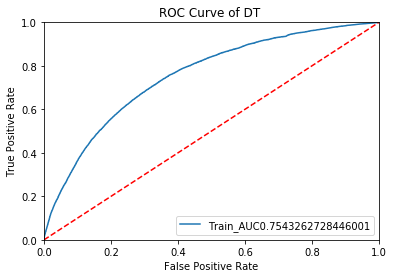

In [95]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = xb_clf1.predict_proba(x_train)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)




plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
#plt.plot(fpr_valid, tpr_valid, label = "Test_AUC"+str(auc(fpr_valid, tpr_valid)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of DT ')
plt.show()


# Submission

In [97]:
y_test_pred = xb_clf1.predict_proba(test_final)

In [98]:


# Get IDs and predictions
#predids=test_orig['impression_id']
#y_id=predids.values.tolist()
preddf=pd.DataFrame({'impression_id':test_final_imp_id,
                     'is_click':y_test_pred[:,1]})

#look at predictions
preddf.head(3)




,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.058639
1,caac14a5bf2ba283db7708bb34855760,0.030869
73,13f10ba306a19ce7bec2f3cae507b698,0.066995


In [99]:
# SAVE DF
preddf.to_csv('submission_new_xgb11.csv',index=False)



# Public Leaderboard : 0.7074514068

# Private Leaderboard : 0.7126746091

# Got 204 rank among 6000+ participants
